# Simulation Workflow from Pre- to Post-Processing


#### Import Libraries


In [5]:
import os
import sys
from pathlib import Path
from dataclasses import dataclass
from datetime import timedelta

import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "ggplot2"
pio.renderers.default = "jupyterlab"

PATH = !pwd 
if 'sumo-uc-2023' not in PATH[0]:
    # this works for windows
    PATH = !cd
ROOT = os.path.join(*Path(PATH[0]).parts[:-2])
if ROOT not in sys.path:
    print(f"adding {ROOT} to path")
    sys.path.append(ROOT)
ROOT = Path(ROOT)

## Processing the Simulation Output


### Load the RW Detector Data


In [6]:
import pandas as pd


In [60]:
output_path = Path("/Volumes/BittleLab/7 DOE Project/sumo-uc-2023/CarFollowingDefaults/EIDM_IDM_KraussAB/77")

START_TIME = pd.to_datetime('2020-02-24 05:30:00')
END_TIME = pd.to_datetime('2020-02-24 11:50:00') #.replace(hour=23, minute=59, second=59)


sumo_df = pd.read_parquet(
    output_path / "detectors.parquet"
)
# add "interval_" to the columns
sumo_df.columns = ["interval_" + col for col in sumo_df.columns]


In [61]:
rw_df = pd.read_parquet(ROOT / "data" / "02_24_2020_cleaned.parquet")


### Convert the SUMO Data to the same format as the RW Data


In [62]:
# create the timestamp column
sumo_df["Timestamp"] = sumo_df["interval_begin"].apply(
    lambda x: START_TIME + timedelta(seconds=x)
)
# make the columns the interval_id & the values the count
sumo_df = (
    sumo_df[["Timestamp", "interval_id", "interval_nVehEntered"]]
    .set_index(["Timestamp", "interval_id"])
    .unstack(
        [
            "interval_id",
        ]
    )
)
# drop the multiindex
sumo_df.columns = sumo_df.columns.droplevel(0)
# reset the index
sumo_df = sumo_df.reset_index()


In [63]:
# sum together detectors that are the "same", (ie. 1_1 and 1_2)
columns = sumo_df.columns.difference(["Timestamp"])
two_level = [
    ("_".join(split_col[:-1]), col)
    for col, split_col in zip(columns, columns.str.split("_"))
]

for short_col, long_col in two_level:
    if short_col in sumo_df.columns:
        sumo_df[short_col] = sumo_df[short_col] + sumo_df[long_col]
    else:
        sumo_df[short_col] = sumo_df[long_col]
    sumo_df.drop(long_col, axis=1, inplace=True)


In [64]:
sumo_df.set_index("Timestamp", inplace=True)


### Resample the RW data to match the sumo data


In [65]:
# resample the rw_df to the sumo_df interval
rw_df = rw_df.resample('1S').sum()
sql_df_day = rw_df.index.mean()
sql_df_day


Timestamp('2020-02-24 11:59:50.499999744', freq='S')

### Create the EB and WB Columns


In [66]:
for tl in ["63082002", "63082003", "63082004"]:
    for ext, detectors in [("EB", [9, 10]), ("WB", [11, 12])]:
        sumo_df[f"{tl}_{ext}"] = sumo_df[[f"{tl}_{d}" for d in detectors]].sum(axis=1)
        rw_df[f"{tl}_{ext}"] = rw_df[[f"{tl}_{d}" for d in detectors]].sum(axis=1)


In [67]:
keep_cols = sumo_df.columns.intersection(rw_df.columns)
sumo_df = sumo_df[keep_cols]
rw_df = rw_df[keep_cols]


### Filter the Data for start and end times

In [68]:
rw_df = rw_df.loc[(rw_df.index <= sumo_df.index[-1]) & (rw_df.index >= sumo_df.index[0])]

### Plot the data


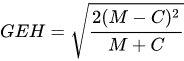


In [69]:
### Calculate the GEH
import numpy as np


def geh(m, c):
    return np.sqrt(2 * (m - c) ** 2 / (m + c))


#### 5 Minute


In [70]:
interval = 3

five_min_sumo = sumo_df.resample(f"{interval}T").sum().copy()
five_min_rw = rw_df.resample(f"{interval}T").sum().copy()
# convert to hourly volumes
five_min_sumo = five_min_sumo * 3600 / (interval * 60)
five_min_rw = five_min_rw * 3600 / (interval * 60)


##### EB


In [71]:
# plot the volume and GEH one 2 y-axis with plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(specs=[[{"secondary_y": True}]])

plot_cols = keep_cols[keep_cols.str.contains("EB")]

# create colors the length of the number of columns
colors = px.colors.qualitative.Plotly * (
    len(plot_cols) // len(px.colors.qualitative.Plotly) + 1
)

for i, col in enumerate(plot_cols):
    fig.add_trace(
        go.Scatter(
            x=five_min_sumo.index,
            y=five_min_sumo[col],
            name=f"Sumo {col}",
            line_color=colors[i],
        )
    )
    fig.add_trace(
        go.Scatter(
            x=five_min_rw.index,
            y=five_min_rw[col],
            name=f"RW {col}",
            line_color=colors[i],
            line_dash="dot",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=five_min_rw.index,
            y=geh(five_min_sumo[col], five_min_rw[col]),
            name=f"GEH {col}",
            line_color=colors[i],
            line_dash="dash",
        ),
        secondary_y=True,
    )

fig.show()


##### WB


In [72]:
# plot the volume and GEH one 2 y-axis with plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(specs=[[{"secondary_y": True}]])

plot_cols = keep_cols[keep_cols.str.contains("WB")]

# create colors the length of the number of columns
colors = px.colors.qualitative.Plotly * (
    len(plot_cols) // len(px.colors.qualitative.Plotly) + 1
)

for i, col in enumerate(plot_cols):
    fig.add_trace(
        go.Scatter(
            x=five_min_sumo.index,
            y=five_min_sumo[col],
            name=f"Sumo {col}",
            line_color=colors[i],
        )
    )
    fig.add_trace(
        go.Scatter(
            x=five_min_rw.index,
            y=five_min_rw[col],
            name=f"RW {col}",
            line_color=colors[i],
            line_dash="dot",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=five_min_rw.index,
            y=geh(five_min_sumo[col], five_min_rw[col]),
            name=f"GEH {col}",
            line_color=colors[i],
            line_dash="dash",
        ),
        secondary_y=True,
    )

fig.show()


#### 10 Minute


In [73]:
interval = 10

five_min_sumo = sumo_df.resample(f"{interval}T", offset="150S").sum().copy()
five_min_rw = rw_df.resample(f"{interval}T", offset="150S").sum().copy()
# convert to hourly volumes
five_min_sumo = five_min_sumo * 3600 / (interval * 60)
five_min_rw = five_min_rw * 3600 / (interval * 60)


##### EB


In [74]:
# plot the volume and GEH one 2 y-axis with plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(specs=[[{"secondary_y": True}]])

plot_cols = keep_cols[keep_cols.str.contains("EB")]

# create colors the length of the number of columns
colors = px.colors.qualitative.Plotly * (
    len(plot_cols) // len(px.colors.qualitative.Plotly) + 1
)

for i, col in enumerate(plot_cols):
    fig.add_trace(
        go.Scatter(
            x=five_min_sumo.index,
            y=five_min_sumo[col],
            name=f"Sumo {col}",
            line_color=colors[i],
        )
    )
    fig.add_trace(
        go.Scatter(
            x=five_min_rw.index,
            y=five_min_rw[col],
            name=f"RW {col}",
            line_color=colors[i],
            line_dash="dot",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=five_min_rw.index,
            y=geh(five_min_sumo[col], five_min_rw[col]),
            name=f"GEH {col}",
            line_color=colors[i],
            line_dash="dash",
        ),
        secondary_y=True,
    )

fig.show()


In [75]:
plot_cols = keep_cols[keep_cols.str.contains("EB")]
for col in plot_cols:
    print(col, geh(five_min_sumo[col], five_min_rw[col]).mean())


63082002_EB 2.8945544061686794
63082003_EB 2.777932437619902
63082004_EB 2.5749894391502393


In [76]:
plot_cols = keep_cols[keep_cols.str.contains("WB")]
for col in plot_cols:
    print(col, geh(five_min_sumo[col], five_min_rw[col]).mean())


63082002_WB 3.155537225902548
63082003_WB 3.092232891358282
63082004_WB 2.6888369210280425


In [77]:
interval = 10
offset = 0

five_min_sumo = sumo_df.resample(f"{interval}T", offset=f"{offset}S").sum().copy()
five_min_rw = rw_df.resample(f"{interval}T", offset=f"{offset}S").sum().copy()
# convert to hourly volumes
five_min_sumo = five_min_sumo * 3600 / (interval * 60)
five_min_rw = five_min_rw * 3600 / (interval * 60)


gehs = []
for col in keep_cols[keep_cols.str.contains("WB")].union(keep_cols[keep_cols.str.contains("EB")]):
    # print(col, geh(five_min_sumo[col], five_min_rw[col]).mean())
    print(col, ((geh(five_min_sumo[col], five_min_rw[col]))).mean() )
    gehs.append(((geh(five_min_sumo[col], five_min_rw[col]))).mean() )

print(np.mean(gehs))


63082002_EB 3.0492933081159834
63082002_WB 2.952400083838512
63082003_EB 2.5166409194650914
63082003_WB 2.7287802414539817
63082004_EB 2.762640500982771
63082004_WB 2.4270774586791637
2.739472085422584


In [19]:
# plot the volume and GEH one 2 y-axis with plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(specs=[[{"secondary_y": True}]])

plot_cols = keep_cols[keep_cols.str.contains("WB")]

# create colors the length of the number of columns
colors = px.colors.qualitative.Plotly * (
    len(plot_cols) // len(px.colors.qualitative.Plotly) + 1
)

for i, col in enumerate(plot_cols):
    fig.add_trace(
        go.Scatter(
            x=five_min_sumo.index,
            y=five_min_sumo[col],
            name=f"Sumo {col}",
            line_color=colors[i],
        )
    )
    fig.add_trace(
        go.Scatter(
            x=five_min_rw.index,
            y=five_min_rw[col],
            name=f"RW {col}",
            line_color=colors[i],
            line_dash="dot",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=five_min_rw.index,
            y=geh(five_min_sumo[col], five_min_rw[col]),
            name=f"GEH {col}",
            line_color=colors[i],
            line_dash="dash",
        ),
        secondary_y=True,
    )

fig.show()


In [20]:
from sumolib.xml import parse_fast_structured

In [21]:
from sumolib.xml import parse_fast_structured

iters = parse_fast_structured(
    str(output_path.absolute() / "fcd.final.out.xml"),
    'timestep', ['time'],
    {'vehicle': ['id']}
)
df = pd.DataFrame(iters)
# df['vehicle'] = df['vehicle'].apply(lambda x: len(x))
df = df.loc[df['time'].astype(float) % 5 <= 0].copy()
df['vehicle'] = df['vehicle'].apply(lambda x: len(x))

In [22]:
import plotly.express as px



# scatter plot with lines and markers
px.scatter(
    df,
    x="time",
    y="vehicle",
    title="Number of Vehicles in Simulation",
    labels={"vehicle": "Number of Vehicles", "time": "Time"},
    template="plotly_white",
    width=800,
    height=400,
)